In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from feature import *
from model import *

/home/lq/.local/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
%%time
train_biz_feats, test_biz_feats = gen_aggregated_feature(aggs=[np.mean])
model, test_L_pred, cv_scores, train_L_pred = run(
    train_biz_feats, train_L, test_biz_feats,
    model = OneVsRestClassifier(LogisticRegression(fit_intercept=False, C=0.1)),
    submission_file='./submission/mean_lr.1.csv',
    cv_evaluation=True)

cv score is: 0.8205895993242746
CPU times: user 9.12 s, sys: 544 ms, total: 9.66 s
Wall time: 18.2 s


# impact of each class on final score

In [83]:
class LogisticRegressionOuputProb(LogisticRegression):
    def predict(self, X):
        return LogisticRegression.predict_proba(self, X)[:,1]

In [87]:
%%time
train_prob_pred = [cross_val_predict(LogisticRegressionOuputProb(fit_intercept=False, C=0.1),
                  train_biz_feats, train_L[:,i],
                  cv=5, n_jobs=1) for i in range(n_labels)]
train_prob_pred = np.array(train_prob_pred).T

CPU times: user 13.3 s, sys: 525 ms, total: 13.9 s
Wall time: 13.9 s


In [4]:
def mean_f1(train_L, train_L_pred):
    return np.array([f1_score(a,b) for (a,b) in zip(train_L, train_L_pred)]).mean()

In [5]:
mean_f1_base = mean_f1(train_L, train_L_pred)
proportion_prior = train_L.mean(axis=0)

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [26]:
mean_f1(train_L, train_L_pred)

0.82058959932427455

In [95]:
%%time
class_impact = []
rng = np.random.RandomState(123)
for i, cls in label_desc_dict.items():
    res = {'class': cls,
           'proportion_prior': proportion_prior[i],
           'precision_single': precision_score(train_L[:,i], train_L_pred[:,i]),
           'recall_single': recall_score(train_L[:,i], train_L_pred[:,i]),
           'f1_single': f1_score(train_L[:,i], train_L_pred[:,i]),
           'auc_single': roc_auc_score(train_L[:,i], train_prob_pred[:,i]),
          }
    
    # perfect
    tmp = train_L_pred.copy()
    tmp[:,i] = train_L[:,i]
    res['perfect'] = mean_f1(train_L, tmp)

    #random
    tmp[:,i] = rng.randint(0, high=2,size=train_L.shape[0])
    res['random'] = mean_f1(train_L, tmp)

    #random_with_prior
    tmp[:,i] = 1*(rng.rand(train_L.shape[0])>proportion_prior[i])
    res['random_with_prior'] = mean_f1(train_L, tmp)
    
    class_impact.append(res)
    
class_impact = pd.DataFrame(class_impact).set_index('class').sort('perfect')

CPU times: user 37.4 s, sys: 72.4 ms, total: 37.5 s
Wall time: 37.6 s


/home/lq/.local/anaconda3/lib/python3.4/site-packages/sklearn/metrics/classification.py:1098: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [96]:
class_impact

auc_single  f1_single   perfect  precision_single  \
class                                                                        
restaurant_is_expensive    0.953225   0.810409  0.829722          0.824197   
has_table_service          0.963631   0.938156  0.833176          0.923132   
ambience_is_classy         0.929500   0.750221  0.833348          0.757576   
good_for_kids              0.934278   0.897249  0.833412          0.898703   
takes_reservations         0.943245   0.877761  0.835849          0.884273   
good_for_dinner            0.916420   0.838481  0.841107          0.843177   
has_alcohol                0.933206   0.887550  0.841537          0.890411   
good_for_lunch             0.874168   0.701504  0.849538          0.748311   
outdoor_seating            0.740920   0.694223  0.861533          0.693532   

                         proportion_prior    random  random_with_prior  \
class                                                                    
restaurant_is_expensive          0.274048  0.778330           0.763933   
has_table_service                0.681363  0.760611           0.752872   
ambience_is_classy               0.286573  0.780860           0.769734   
good_for_kids                    0.620240  0.736417           0.722498   
takes_reservations               0.514028  0.775607           0.776786   
good_for_dinner                  0.497495  0.778646           0.779966   
has_alcohol                      0.625752  0.775974           0.771222   
good_for_lunch                   0.336172  0.779003           0.782631   
outdoor_seating                  0.502505  0.790009           0.792757   

                         recall_single  
class                                   
restaurant_is_expensive       0.797075  
has_table_service             0.953676  
ambience_is_classy            0.743007  
good_for_kids                 0.895800  
takes_reservations            0.871345  
good_for_dinner               0.833837  
has_alcohol                   0.884708  
good_for_lunch                0.660209  
outdoor_seating               0.694915

In [105]:
n_labels

9

In [108]:
%matplotlib inline
import seaborn
seaborn.set()

# distribution of predicted probability

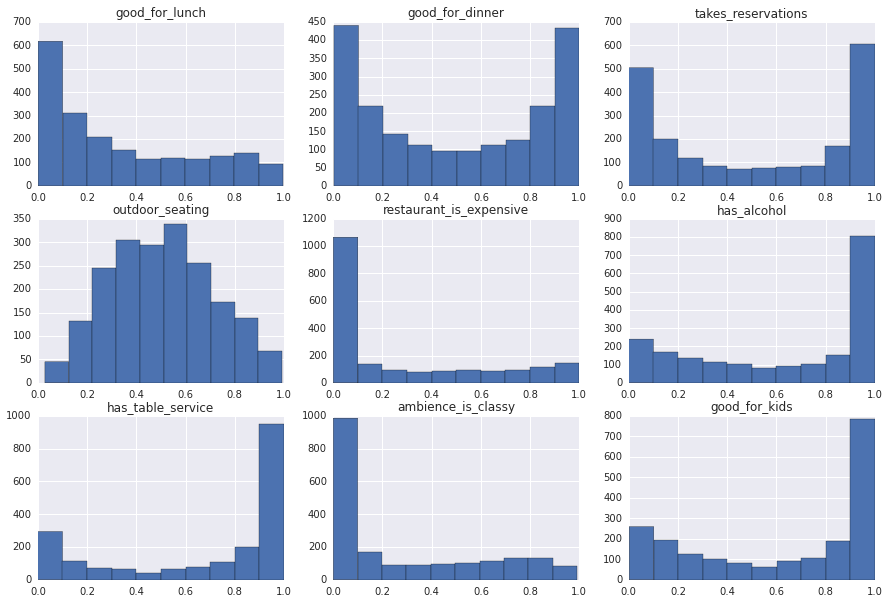

In [111]:
fig, axes = plt.subplots(3,3, figsize=(15,10))
for i, ax in enumerate(axes.ravel()):
    ax.hist(train_prob_pred[:,i])
    ax.set_title(label_desc_dict[i])

## outdoor_seating

In [112]:
label_desc_dict

{0: 'good_for_lunch',
 1: 'good_for_dinner',
 2: 'takes_reservations',
 3: 'outdoor_seating',
 4: 'restaurant_is_expensive',
 5: 'has_alcohol',
 6: 'has_table_service',
 7: 'ambience_is_classy',
 8: 'good_for_kids'}

In [114]:
pd.Series(train_L[:,3]).value_counts()

1    1003
0     993
dtype: int64